# Movement detection

In this script, we process the motion tracking and build a pipeline to automatically detect a movement event within a specific marker (e.g., wrist, head, ...)

These are then used to compare them with manual annotations and evaluate the performance of the algorithm.


## Folder settings

In [2]:
import os
import glob

curfolder = os.getcwd()
print(curfolder)

# data are in curfolder/P0/P0/
datafolder = curfolder + '/P0/P0/'
print(datafolder)
folderstotrack = glob.glob(datafolder + '/*')
# put away config
folderstotrack = [x for x in folderstotrack if 'Config' not in x]
print(folderstotrack)

c:\Users\Sarka Kadava\Documents\Github\FLESH_ContinuousBodilyEffort\TS_processing
c:\Users\Sarka Kadava\Documents\Github\FLESH_ContinuousBodilyEffort\TS_processing/P0/P0/
['c:\\Users\\Sarka Kadava\\Documents\\Github\\FLESH_ContinuousBodilyEffort\\TS_processing/P0/P0\\0_1_0_p0', 'c:\\Users\\Sarka Kadava\\Documents\\Github\\FLESH_ContinuousBodilyEffort\\TS_processing/P0/P0\\0_1_18_p0', 'c:\\Users\\Sarka Kadava\\Documents\\Github\\FLESH_ContinuousBodilyEffort\\TS_processing/P0/P0\\0_1_19_p0', 'c:\\Users\\Sarka Kadava\\Documents\\Github\\FLESH_ContinuousBodilyEffort\\TS_processing/P0/P0\\0_1_1_p0', 'c:\\Users\\Sarka Kadava\\Documents\\Github\\FLESH_ContinuousBodilyEffort\\TS_processing/P0/P0\\0_1_20_p0', 'c:\\Users\\Sarka Kadava\\Documents\\Github\\FLESH_ContinuousBodilyEffort\\TS_processing/P0/P0\\0_1_21_p0', 'c:\\Users\\Sarka Kadava\\Documents\\Github\\FLESH_ContinuousBodilyEffort\\TS_processing/P0/P0\\0_1_22_p0', 'c:\\Users\\Sarka Kadava\\Documents\\Github\\FLESH_ContinuousBodilyEffort\

# Extraction of MT features

Note that y and z dimensions are swapped (such that z is vertical)

In [3]:
import pandas as pd
import scipy
import numpy as np

# initiate empty list for dfs
dfs = []

for folder in folderstotrack:
    # last element is trialid
    trialid = folder.split('\\')[-1]
    #print(trialid)
    # PREPARING MT
    csvfiles = glob.glob(folder + '/**/*.csv', recursive=True)
    butterfile = csvfiles[1] # this one is buttered

    # load it
    mt = pd.read_csv(butterfile)

    # show columns
    cols = mt.columns

    # put away 'Time' column from the list ( the last)
    cols = cols[:-1]

    # put away from each colname anything behind _ (including _)
    cols = [x.split('_')[0] for x in cols]

    # keep unique
    colsforspeed = list(set(cols))

    # smooth all columns except time with savgol 15,3
    colstosmooth = mt.columns[:-1]

    mt_smooth = pd.DataFrame()

    for col in colstosmooth:
        mt_smooth[col] = scipy.signal.savgol_filter(mt[col], 15, 3)
        # and put them all to cms
        mt_smooth[col] = mt_smooth[col]*100

    # add time column
    mt_smooth['Time'] = mt['Time']

    # what is the sampling rate
    sr = 1/np.mean(np.diff(mt['Time']))

    # for each unique colname (cols), calculate speed from x and y dimensions (_x, _y)
    for col in colsforspeed:
        # get x and y columns
        x = mt_smooth[col + '_x']
        y = mt_smooth[col + '_y']
        z = mt_smooth[col + '_z']
        # calculate speed
        #speed = (x.diff()**2 + y.diff()**2)**0.5
        # add to dataframe
        mt_smooth[col + '_speed'] = np.insert(np.sqrt(np.diff(x)**2 + np.diff(y)**2 + np.diff(z)**2), 0, 0)
        # multiply the values by sr, because now we have values in m/(s/sr)
        mt_smooth[col + '_speed'] = mt_smooth[col + '_speed']*sr
        
        # smooth with savgol 15, 3
        mt_smooth[col + '_speed'] = scipy.signal.savgol_filter(mt_smooth[col + '_speed'], 15, 3)

        # for each of these columns, create a col_movement column
        mt_smooth[col + '_movement'] = None
        # if the speed in col_speed is above 15, then movement is 1, else 0
        mt_smooth.loc[mt_smooth[col + '_speed'] >= 15, col + '_movement'] = 1
        mt_smooth.loc[mt_smooth[col + '_speed'] < 15, col + '_movement'] = 0

        # annotate events
        mt_smooth[col + '_event'] = (mt_smooth[col + '_movement'] != mt_smooth[col + '_movement'].shift(1)) & (mt_smooth[col + '_movement'] == 1)
        mt_smooth[col + '_event'] = mt_smooth[col + '_event'].cumsum()
        # if there is no movement, then event is 0
        mt_smooth.loc[mt_smooth[col + '_movement'] == 0, col + '_event'] = 0

        # if the col contains wrist, we will alco calculate the vertical velocity (z dimension)
        if 'Wrist' in col:
            # calculate speed
            #speed = (x.diff()**2 + y.diff()**2)**0.5
            # add to dataframe
            mt_smooth[col + '_vert_vel'] = np.insert(np.diff(z), 0, 0)
            # multiply the values by sr, because now we have values in m/(s/sr)
            mt_smooth[col + '_vert_vel'] = mt_smooth[col + '_vert_vel']*sr

            # smooth with savgol 15, 3
            mt_smooth[col + '_vert_vel'] = scipy.signal.savgol_filter(mt_smooth[col + '_vert_vel'], 15, 3)

            # for each of these columns, create a col_movement column
            mt_smooth[col + '_vv_movement'] = None
            # if the speed in col_speed is smaller than -15 or bigger than 15, then movement is 1, else 0
            mt_smooth.loc[(mt_smooth[col + '_vert_vel'] >= 15) | (mt_smooth[col + '_vert_vel'] <= -15), col + '_vv_movement'] = 1
            mt_smooth.loc[(mt_smooth[col + '_vert_vel'] < 15) & (mt_smooth[col + '_vert_vel'] > -15), col + '_vv_movement'] = 0
            # annotate events
            mt_smooth[col + '_vv_movement_event'] = (mt_smooth[col + '_vv_movement'] != mt_smooth[col + '_vv_movement'].shift(1)) & (mt_smooth[col + '_vv_movement'] == 1)
            mt_smooth[col + '_vv_movement_event'] = mt_smooth[col + '_vv_movement_event'].cumsum()
            # if there is no movement, then event is 0
            mt_smooth.loc[mt_smooth[col + '_vv_movement'] == 0, col + '_vv_movement_event'] = 0
            
    # add trialid
    mt_smooth['TrialID'] = trialid
    # convert time to ms
    mt_smooth['Time'] = mt_smooth['Time']*1000

    # append to dfs
    dfs.append(mt_smooth)
    

C:\Users\Sarka Kadava\AppData\Local\Temp\ipykernel_4788\1574215726.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mt_smooth[col + '_speed'] = np.insert(np.sqrt(np.diff(x)**2 + np.diff(y)**2 + np.diff(z)**2), 0, 0)
C:\Users\Sarka Kadava\AppData\Local\Temp\ipykernel_4788\1574215726.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mt_smooth[col + '_movement'] = None
C:\Users\Sarka Kadava\AppData\Local\Temp\ipykernel_4788\1574215726.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of c

In [4]:
sample = dfs[14]

In [5]:
# make a sample copy
samplecopy = sample.copy()

# keep only columns with speed and movement
samplecopy = samplecopy[[x for x in samplecopy.columns if 'speed' in x or 'movement' in x or 'Time' in x or 'event' in x or 'vert_vel' in x]]

In [6]:
samplecopy

,Time,LAnkle_speed,LAnkle_movement,LAnkle_event,LHeel_speed,LHeel_movement,LHeel_event,LHip_speed,LHip_movement,LHip_event,...,Nose_event,LShoulder_speed,LShoulder_movement,LShoulder_event,RHip_speed,RHip_movement,RHip_event,LSmallToe_speed,LSmallToe_movement,LSmallToe_event
0,16.666667,8.780302,0,0,6.195924,0,0,-1.411370,0,0,...,0,1.663870,0,0,-0.134077,0,0,4.054215,0,0
1,33.333333,7.837390,0,0,5.714276,0,0,1.377993,0,0,...,0,1.396315,0,0,2.497753,0,0,4.026296,0,0
2,50.000000,7.390624,0,0,5.379749,0,0,3.076134,0,0,...,1,1.248370,0,0,4.066118,0,0,3.933456,0,0
3,66.666667,7.341070,0,0,5.160896,0,0,3.898223,0,0,...,1,1.227254,0,0,4.802031,0,0,3.830783,0,0
4,83.333333,7.589794,0,0,5.026270,0,0,4.059426,0,0,...,0,1.340189,0,0,4.936510,0,0,3.773362,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,5300.000000,4.175106,0,0,4.082480,0,0,7.791979,0,0,...,0,1.728604,0,0,4.565819,0,0,1.090037,0,0
318,5316.666667,6.086796,0,0,4.817126,0,0,8.579650,0,0,...,0,1.726430,0,0,6.134899,0,0,1.243101,0,0
319,5333.333333,9.146857,0,0,5.925835,0,0,9.103831,0,0,...,0,2.158934,0,0,9.384263,0,0,2.674058,0,0
320,5350.000000,13.534186,0,0,7.482460,0,0,9.198080,0,0,...,0,3.126175,0,0,14.675534,0,0,5.669874,0,0


In [7]:

# Initialize variables
chunks = []
current_chunk = None

# get event columns
eventcols = [x for x in samplecopy.columns if 'event' in x]
# get our all with duration in
eventcols = [x for x in eventcols if 'duration' not in x]
# get out all wrist cols
eventcols = [x for x in eventcols if 'Wrist_event' not in x]

# Function to get chunks from a column
def get_chunks(df, time_col, event_col):
    chunks = []
    current_chunk = None

    for idx, row in df.iterrows():
        if current_chunk is None:
            current_chunk = {'value': row[event_col], 'start_idx': idx, 'start_time': row[time_col]}
        elif row[event_col] != current_chunk['value']:
            current_chunk['end_idx'] = idx - 1
            current_chunk['end_time'] = df.loc[idx - 1, time_col]
            chunks.append(current_chunk)
            current_chunk = {'value': row[event_col], 'start_idx': idx, 'start_time': row[time_col]}
        if idx == len(df) - 1:
            current_chunk['end_idx'] = idx
            current_chunk['end_time'] = row[time_col]
            chunks.append(current_chunk)

    chunk_data = []
    for chunk in chunks:
        duration = chunk['end_time'] - chunk['start_time']
        chunk_data.append([chunk['value'], chunk['start_idx'], chunk['end_idx'], duration])

    chunks_df = pd.DataFrame(chunk_data, columns=['value', 'start_idx', 'end_idx', 'duration'])
    return chunks_df

# Dictionary to store results for each column
chunk_results = {}

# Loop through each event column and apply the function
for col in eventcols:
    chunks_df = get_chunks(samplecopy, 'Time', col)
    chunk_results[col] = chunks_df


In [8]:
# turn the dictionary into a list, also with info about column
chunks = []
for col, df in chunk_results.items():
    df['column'] = col
    chunks.append(df)

In [9]:
for chunk in chunks:
    print(chunk)
    col = chunk['column'][0]
    df = chunk
    ## MERGING
    short_pauses = []
    # print rows that have value 0 and duration less than 250
    print(df[(df['value'] == 0) & (df['duration'] < 250)])
    
    # if these rows do not contain first and last row, append them to short_pauses
    for idx, row in df[(df['value'] == 0) & (df['duration'] < 250)].iterrows():
        if idx != 0 and idx != len(df) - 1:
            short_pauses.append(row)
    # if short pauses is empty, we do not need to merge anything
    if not short_pauses:
        print('we do not need to merge')
    else:
        print('we need to merge')
        print(short_pauses)
        # check what is the value of the previous row and the next row in chunk
        for pause in short_pauses:
            # get the index of the row in df
            idx = pause.name
        
            # get the index of the previous row
            prev_idx = idx - 1
            # print the previous row
            print('previous row', df.loc[prev_idx])
            # get the start index of the previous row
            new_start_index = df.loc[prev_idx, 'start_idx']
            # value of the previous row
            prev_value = df.loc[prev_idx, 'value']
            # get the index of the next row
            next_idx = idx + 1
            # print the next row
            print('next row', df.loc[next_idx])
            # get the end index of the next row
            new_end_idx = df.loc[next_idx, 'end_idx']
            # everything from new_start_index to new_end_idx should be merged and named as previous value
            # in the original dataframe, set the value to the previous value in this range
            samplecopy.loc[new_start_index:new_end_idx, col] = prev_value

   


   value  start_idx  end_idx     duration        column
0      0          0       31   516.666667  LAnkle_event
1      1         32       33    16.666667  LAnkle_event
2      0         34      320  4766.666667  LAnkle_event
3      2        321      321     0.000000  LAnkle_event
Empty DataFrame
Columns: [value, start_idx, end_idx, duration, column]
Index: []
we do not need to merge
   value  start_idx  end_idx  duration       column
0      0          0      321    5350.0  LHeel_event
Empty DataFrame
Columns: [value, start_idx, end_idx, duration, column]
Index: []
we do not need to merge
    value  start_idx  end_idx     duration      column
0       0          0       13   216.666667  LHip_event
1       1         14       34   333.333333  LHip_event
2       0         35       41   100.000000  LHip_event
3       2         42       67   416.666667  LHip_event
4       0         68      104   600.000000  LHip_event
5       3        105      105     0.000000  LHip_event
6       0        106 

In [10]:
# apply the chunk function again on the new dataframe

# Dictionary to store results for each column
chunk_results_new = {}

# Loop through each event column and apply the function
for col in eventcols:
    chunks_df = get_chunks(samplecopy, 'Time', col)
    chunk_results_new[col] = chunks_df


# turn the dictionary into a list, also with info about column
chunks_new = []
for col, df in chunk_results_new.items():
    df['column'] = col
    chunks_new.append(df)

In [11]:
merged_all = []

for df in chunks_new:
    print(df)
    # Filter rows with non-zero values
    non_zero_rows = df[df['value'] != 0].reset_index(drop=True)
    
    print(non_zero_rows)
    # Initialize list to store merged segments
    merged_segments = []

    # if the non_zero rows is empty, we do not need to do anything
    if non_zero_rows.empty:
        print('no non-zero rows')
        continue
    else:
        # Initialize variables to track current segment
        current_segment = non_zero_rows.iloc[0].copy()

        # Iterate through non-zero rows to merge consecutive segments
        for i in range(1, len(non_zero_rows)):
            row = non_zero_rows.iloc[i]
            print(row)
        
            if current_segment['end_idx'] + 1 == row['start_idx']:
                # Merge segments
                current_segment['end_idx'] = row['end_idx']
                current_segment['duration'] += row['duration']
            else:
                # Append current segment to merged segments list
                merged_segments.append(current_segment)
                # Start new segment
                current_segment = row.copy()

    # Append the last segment
    merged_segments.append(current_segment)

    # Convert list of merged segments to dataframe
    merged_df = pd.DataFrame(merged_segments)

    # append to merged_all
    merged_all.append(merged_df)


   value  start_idx  end_idx     duration        column
0      0          0       31   516.666667  LAnkle_event
1      1         32       33    16.666667  LAnkle_event
2      0         34      320  4766.666667  LAnkle_event
3      2        321      321     0.000000  LAnkle_event
   value  start_idx  end_idx   duration        column
0      1         32       33  16.666667  LAnkle_event
1      2        321      321   0.000000  LAnkle_event
value                   2
start_idx             321
end_idx               321
duration              0.0
column       LAnkle_event
Name: 1, dtype: object
   value  start_idx  end_idx  duration       column
0      0          0      321    5350.0  LHeel_event
Empty DataFrame
Columns: [value, start_idx, end_idx, duration, column]
Index: []
no non-zero rows
   value  start_idx  end_idx     duration      column
0      0          0       13   216.666667  LHip_event
1      1         14       67   883.333333  LHip_event
2      0         68      104   600.000000

In [12]:
for chunk in merged_all:
    print(chunk)
    for _, row in chunk.iterrows():
        print(row)
        start = row['start_idx']
        end = row['end_idx']
        value = row['value']
        column = row['column']

        # Update the corresponding column in samplecopy
        samplecopy.loc[start:end, column] = value



   value  start_idx  end_idx   duration        column
0      1         32       33  16.666667  LAnkle_event
1      2        321      321   0.000000  LAnkle_event
value                   1
start_idx              32
end_idx                33
duration        16.666667
column       LAnkle_event
Name: 0, dtype: object
value                   2
start_idx             321
end_idx               321
duration              0.0
column       LAnkle_event
Name: 1, dtype: object
   value  start_idx  end_idx     duration      column
0      1         14       67   883.333333  LHip_event
1      3        105      105     0.000000  LHip_event
2      4        137      139    33.333333  LHip_event
3      5        232      294  1033.333333  LHip_event
value                 1
start_idx            14
end_idx              67
duration     883.333333
column       LHip_event
Name: 0, dtype: object
value                 3
start_idx           105
end_idx             105
duration            0.0
column       LHip_event

In [13]:
# perform the chunk function again

# Dictionary to store results for each column
chunk_results_final = {}

# Loop through each event column and apply the function
for col in eventcols:
    chunks_df = get_chunks(samplecopy, 'Time', col)
    chunk_results_final[col] = chunks_df

# convert dict into list
chunks_final = []

# convert
for col, df in chunk_results_final.items():
    df['column'] = col
    chunks_final.append(df)

In [14]:
chunks_final

[   value  start_idx  end_idx     duration        column
 0      0          0       31   516.666667  LAnkle_event
 1      1         32       33    16.666667  LAnkle_event
 2      0         34      320  4766.666667  LAnkle_event
 3      2        321      321     0.000000  LAnkle_event,
    value  start_idx  end_idx  duration       column
 0      0          0      321    5350.0  LHeel_event,
    value  start_idx  end_idx     duration      column
 0      0          0       13   216.666667  LHip_event
 1      1         14       67   883.333333  LHip_event
 2      0         68      104   600.000000  LHip_event
 3      3        105      105     0.000000  LHip_event
 4      0        106      136   500.000000  LHip_event
 5      4        137      139    33.333333  LHip_event
 6      0        140      231  1516.666667  LHip_event
 7      5        232      294  1033.333333  LHip_event
 8      0        295      321   433.333333  LHip_event,
    value  start_idx  end_idx     duration              

In [15]:
for chunk in chunks_final:
    print(chunk)
    col = chunk['column'][0]
    df = chunk

 ## FAKE EVENTS
    nomov = []  
    # print rows that dont have value 0 and duration less than 200
    print(df[(df['value'] != 0) & (df['duration'] < 200)])
    # add those to nomov
    for idx, row in df[(df['value'] != 0) & (df['duration'] < 200)].iterrows():
        nomov.append(row)

    print(nomov)
    # if nomov is empty, we do not need to do anything
    if not nomov:
        ('no fake events found')
    else:
        # these fake events need to be turned into 0s in the original dataframe
        print('we need to turn fake events into 0s')
        # for each row in nomov, set the value in the original dataframe to 0
        for chunk in nomov:
            start = int(chunk['start_idx'])
            end = int(chunk['end_idx'])
            # in the original dataframe, set the value to 0 in this range
            samplecopy.loc[start:end, col] = 0


   value  start_idx  end_idx     duration        column
0      0          0       31   516.666667  LAnkle_event
1      1         32       33    16.666667  LAnkle_event
2      0         34      320  4766.666667  LAnkle_event
3      2        321      321     0.000000  LAnkle_event
   value  start_idx  end_idx   duration        column
1      1         32       33  16.666667  LAnkle_event
3      2        321      321   0.000000  LAnkle_event
[value                   1
start_idx              32
end_idx                33
duration        16.666667
column       LAnkle_event
Name: 1, dtype: object, value                   2
start_idx             321
end_idx               321
duration              0.0
column       LAnkle_event
Name: 3, dtype: object]
we need to turn fake events into 0s
   value  start_idx  end_idx  duration       column
0      0          0      321    5350.0  LHeel_event
Empty DataFrame
Columns: [value, start_idx, end_idx, duration, column]
Index: []
[]
   value  start_idx  end_

In [20]:
# lets do chunks again, but only on wrist event cols
wristcols = [x for x in samplecopy.columns if 'Wrist' in x]

# keep only those that have movement and event in
wristcols = [x for x in wristcols if 'event' in x]

In [22]:
# now the chunk function

# Dictionary to store results for each column
wchunk_results_final = {}

# Loop through each event column and apply the function
for col in wristcols:
    wchunks_df = get_chunks(samplecopy, 'Time', col)
    wchunk_results_final[col] = wchunks_df

# convert dict into list
wchunks_final = []

# convert
for col, df in wchunk_results_final.items():
    df['column'] = col
    wchunks_final.append(df)

In [23]:
wchunks_final

[   value  start_idx  end_idx     duration        column
 0      0          0        9   150.000000  LWrist_event
 1      1         10       67   950.000000  LWrist_event
 2      0         68      156  1466.666667  LWrist_event
 3      2        157      159    33.333333  LWrist_event
 4      0        160      259  1650.000000  LWrist_event
 5      3        260      297   616.666667  LWrist_event
 6      0        298      321   383.333333  LWrist_event,
    value  start_idx  end_idx     duration                    column
 0      0          0      261  4350.000000  LWrist_vv_movement_event
 1      2        262      279   283.333333  LWrist_vv_movement_event
 2      0        280      321   683.333333  LWrist_vv_movement_event,
    value  start_idx  end_idx     duration        column
 0      0          0        8   133.333333  RWrist_event
 1      1          9       34   416.666667  RWrist_event
 2      0         35       46   183.333333  RWrist_event
 3      2         47      139  1533.33

In [32]:
leftspeed = wchunks_final[0]
rightspeed = wchunks_final[2]
leftvel = wchunks_final[1]
rightvel = wchunks_final[3]

lefttocheck = leftspeed[leftspeed['value'] != 0]
righttocheck = rightspeed[rightspeed['value'] != 0]

leftzero = leftvel[leftvel['value'] == 0]
rightzero = rightvel[rightvel['value'] == 0]

# Function to check if there is any overlap
def check_overlap(non_zero_df, zero_df, wrist_name):
    first_non_zero = non_zero_df.iloc[0]
    last_non_zero = non_zero_df.iloc[-1]

    startstodel = []
    endstodel = []
    
    for zero_row in zero_df.itertuples(index=False):
        # Check if the first non-zero chunk is completely within the zero chunk
        if first_non_zero.start_idx >= zero_row.start_idx and first_non_zero.end_idx <= zero_row.end_idx:
            print(f"First non-zero chunk {first_non_zero.start_idx}-{first_non_zero.end_idx} in {first_non_zero.column} is completely within zero chunk {zero_row.start_idx}-{zero_row.end_idx} in {wrist_name}_vv_event")
            # attach the start and end index of this chunk
            startstodel.append(first_non_zero.start_idx)
            endstodel.append(first_non_zero.end_idx)
            
        
        # Check if the last non-zero chunk is completely within the zero chunk
        if last_non_zero.start_idx >= zero_row.start_idx and last_non_zero.end_idx <= zero_row.end_idx:
            print(f"Last non-zero chunk {last_non_zero.start_idx}-{last_non_zero.end_idx} in {last_non_zero.column} is completely within zero chunk {zero_row.start_idx}-{zero_row.end_idx} in {wrist_name}_vv_event")
            # attach
            startstodel.append(last_non_zero.start_idx)
            endstodel.append(last_non_zero.end_idx)

    return startstodel, endstodel



# Check for overlaps
print("Checking LWrist_event vs LWrist_vv_event")
sindex1, eindex1 = check_overlap(lefttocheck, leftzero, "LWrist")
# replace the values in the original dataframe with 0
for start, end in zip(sindex1, eindex1):
    samplecopy.loc[start:end, 'LWrist_event'] = 0

print("\nChecking RWrist_event vs RWrist_vv_event")
sindex2, eindex2 =check_overlap(righttocheck, rightzero, "RWrist")
# replace the values in the original dataframe with 0
for start, end in zip(sindex2, eindex2):
    samplecopy.loc[start:end, 'RWrist_event'] = 0


Checking LWrist_event vs LWrist_vv_event
First non-zero chunk 10-67 in LWrist_event is completely within zero chunk 0-261 in LWrist_vv_event

Checking RWrist_event vs RWrist_vv_event
First non-zero chunk 9-34 in RWrist_event is completely within zero chunk 0-49 in RWrist_vv_event
Last non-zero chunk 308-314 in RWrist_event is completely within zero chunk 281-321 in RWrist_vv_event


In [33]:
# now I want only Wrist_event cols

wristcols = [x for x in samplecopy.columns if 'Wrist_event' in x]

In [34]:
# perform chunks on it

# Dictionary to store results for each column
wristchunk_results_final = {}

# Loop through each event column and apply the function
for col in wristcols:
    wristchunks_df = get_chunks(samplecopy, 'Time', col)
    wristchunk_results_final[col] = wristchunks_df

# convert dict into list
wristchunks_final = []

# convert
for col, df in wristchunk_results_final.items():
    df['column'] = col
    wristchunks_final.append(df)

wristchunks_final

[   value  start_idx  end_idx     duration        column
 0      0          0      156  2600.000000  LWrist_event
 1      2        157      159    33.333333  LWrist_event
 2      0        160      259  1650.000000  LWrist_event
 3      3        260      297   616.666667  LWrist_event
 4      0        298      321   383.333333  LWrist_event,
    value  start_idx  end_idx     duration        column
 0      0          0       46   766.666667  RWrist_event
 1      2         47      139  1533.333333  RWrist_event
 2      0        140      145    83.333333  RWrist_event
 3      3        146      294  2466.666667  RWrist_event
 4      0        295      321   433.333333  RWrist_event]

In [35]:
# check for short pauses

for chunk in wristchunks_final:
    print(chunk)
    col = chunk['column'][0]
    df = chunk
    ## MERGING
    short_pauses = []
    # print rows that have value 0 and duration less than 250
    print(df[(df['value'] == 0) & (df['duration'] < 250)])
    
    # if these rows do not contain first and last row, append them to short_pauses
    for idx, row in df[(df['value'] == 0) & (df['duration'] < 250)].iterrows():
        if idx != 0 and idx != len(df) - 1:
            short_pauses.append(row)
    # if short pauses is empty, we do not need to merge anything
    if not short_pauses:
        print('we do not need to merge')
    else:
        print('we need to merge')
        print(short_pauses)
        # check what is the value of the previous row and the next row in chunk
        for pause in short_pauses:
            # get the index of the row in df
            idx = pause.name
        
            # get the index of the previous row
            prev_idx = idx - 1
            # print the previous row
            print('previous row', df.loc[prev_idx])
            # get the start index of the previous row
            new_start_index = df.loc[prev_idx, 'start_idx']
            # value of the previous row
            prev_value = df.loc[prev_idx, 'value']
            # get the index of the next row
            next_idx = idx + 1
            # print the next row
            print('next row', df.loc[next_idx])
            # get the end index of the next row
            new_end_idx = df.loc[next_idx, 'end_idx']
            # everything from new_start_index to new_end_idx should be merged and named as previous value
            # in the original dataframe, set the value to the previous value in this range
            samplecopy.loc[new_start_index:new_end_idx, col] = prev_value



   value  start_idx  end_idx     duration        column
0      0          0      156  2600.000000  LWrist_event
1      2        157      159    33.333333  LWrist_event
2      0        160      259  1650.000000  LWrist_event
3      3        260      297   616.666667  LWrist_event
4      0        298      321   383.333333  LWrist_event
Empty DataFrame
Columns: [value, start_idx, end_idx, duration, column]
Index: []
we do not need to merge
   value  start_idx  end_idx     duration        column
0      0          0       46   766.666667  RWrist_event
1      2         47      139  1533.333333  RWrist_event
2      0        140      145    83.333333  RWrist_event
3      3        146      294  2466.666667  RWrist_event
4      0        295      321   433.333333  RWrist_event
   value  start_idx  end_idx   duration        column
2      0        140      145  83.333333  RWrist_event
we need to merge
[value                   0
start_idx             140
end_idx               145
duration        83.

In [36]:
# apply the chunk function again on the new dataframe

# Dictionary to store results for each column
wristchunk_results_new = {}

# Loop through each event column and apply the function
for col in wristcols:
    wristchunks_df = get_chunks(samplecopy, 'Time', col)
    wristchunk_results_new[col] = wristchunks_df

# turn the dictionary into a list, also with info about column
wristchunks_new = []
for col, df in wristchunk_results_new.items():
    df['column'] = col
    wristchunks_new.append(df)

wristchunks_new

[   value  start_idx  end_idx     duration        column
 0      0          0      156  2600.000000  LWrist_event
 1      2        157      159    33.333333  LWrist_event
 2      0        160      259  1650.000000  LWrist_event
 3      3        260      297   616.666667  LWrist_event
 4      0        298      321   383.333333  LWrist_event,
    value  start_idx  end_idx     duration        column
 0      0          0       46   766.666667  RWrist_event
 1      2         47      294  4116.666667  RWrist_event
 2      0        295      321   433.333333  RWrist_event]

In [37]:
# check for fake events

for chunk in wristchunks_new:
    print(chunk)
    col = chunk['column'][0]
    df = chunk
 ## FAKE EVENTS
    nomov = []  
    # print rows that dont have value 0 and duration less than 200
    print(df[(df['value'] != 0) & (df['duration'] < 200)])
    # add those to nomov
    for idx, row in df[(df['value'] != 0) & (df['duration'] < 200)].iterrows():
        nomov.append(row)

    print(nomov)
    # if nomov is empty, we do not need to do anything
    if not nomov:
        ('no fake events found')
    else:
        # these fake events need to be turned into 0s in the original dataframe
        print('we need to turn fake events into 0s')
        # for each row in nomov, set the value in the original dataframe to 0
        for chunk in nomov:
            start = int(chunk['start_idx'])
            end = int(chunk['end_idx'])
            # in the original dataframe, set the value to 0 in this range
            samplecopy.loc[start:end, col] = 0

   value  start_idx  end_idx     duration        column
0      0          0      156  2600.000000  LWrist_event
1      2        157      159    33.333333  LWrist_event
2      0        160      259  1650.000000  LWrist_event
3      3        260      297   616.666667  LWrist_event
4      0        298      321   383.333333  LWrist_event
   value  start_idx  end_idx   duration        column
1      2        157      159  33.333333  LWrist_event
[value                   2
start_idx             157
end_idx               159
duration        33.333333
column       LWrist_event
Name: 1, dtype: object]
we need to turn fake events into 0s
   value  start_idx  end_idx     duration        column
0      0          0       46   766.666667  RWrist_event
1      2         47      294  4116.666667  RWrist_event
2      0        295      321   433.333333  RWrist_event
Empty DataFrame
Columns: [value, start_idx, end_idx, duration, column]
Index: []
[]


# Peak detection

In [64]:
from scipy.signal import find_peaks
from scipy.signal import peak_widths

# find peaks in the speed
peakcols = [x for x in samplecopy.columns if 'speed' in x]

for col in peakcols:
    # find peaks
    peaks, _ = find_peaks(samplecopy[col], height=15)
    # add peaks to the dataframe
    samplecopy[col + '_peak'] = 0
    samplecopy.loc[peaks, col + '_peak'] = 1
    # find widths

    widths_7 = peak_widths(samplecopy[col], peaks, rel_height=0.7)
    widths_5 = peak_widths(samplecopy[col], peaks, rel_height=0.5)
    widths_3 = peak_widths(samplecopy[col], peaks, rel_height=0.3)
    widths_1 = peak_widths(samplecopy[col], peaks, rel_height=1)
    break
    # add widths to the dataframe
    samplecopy[col + '_width'] = widths[0]


In [50]:
peaks

array([ 17,  30,  55, 244, 290], dtype=int64)

In [43]:
print(col)

RHip_speed


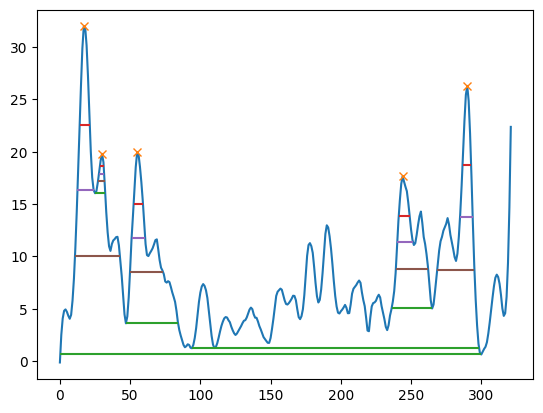

In [65]:
import matplotlib.pyplot as plt

x = samplecopy[col]

plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.hlines(*widths_1[1:], color="C2")
plt.hlines(*widths_3[1:], color="C3")
plt.hlines(*widths_5[1:], color="C4")
plt.hlines(*widths_7[1:], color="C5")
plt.show()